<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: cornflowerblue;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 30px;
              color:snow;"> Sistema de Visión

</h2>
</div>

<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightblue;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 20px;
              color:snow;"> Detección de pupilas 

</h2>
</div>

In [2]:
import cv2
import dlib
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [8]:
pip install dlib opencv-python numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install dlib

Note: you may need to restart the kernel to use updated packages.


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 10px;
              color:snow;"> Procesamiento de visión para ambos ojos

</h2>
</div>


In [21]:

class MovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []

    def add_value(self, value):
        self.values.append(value)
        if len(self.values) > self.window_size:
            self.values.pop(0)

    def get_average(self):
        if self.values:
            return sum(self.values) / len(self.values)
        return 0
        
def gaussian_smoothing(values, sigma=2):
    # Asegúrate de que hay suficientes valores para aplicar el suavizado
    if len(values) > 1:
        return cv2.GaussianBlur(np.array(values, dtype=np.float32), (0, 0), sigma).flatten()
    return values
    
# Inicializar el detector de rostros y el predictor de puntos de referencia
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Cargar el video
cap = cv2.VideoCapture("VIDEOS/6SUJ.mp4")
# Inicializa los promedios móviles para las coordenadas del centro de la pupila
center_x_avg = MovingAverage(5)  # Ajusta el tamaño de la ventana como sea necesario
center_y_avg = MovingAverage(5)

    
def get_eye_region(landmarks, eye_indices):
    region = np.array([(landmarks.part(point).x, landmarks.part(point).y) for point in eye_indices], np.int32)
    return region

def detect_iris(eye_region, frame):
    mask = np.zeros_like(frame)
    cv2.polylines(mask, [eye_region], True, 255, 2)
    cv2.fillPoly(mask, [eye_region], 255)
    eye = cv2.bitwise_and(frame, frame, mask=mask[:,:,0])

    min_x = np.min(eye_region[:, 0])
    max_x = np.max(eye_region[:, 0])
    min_y = np.min(eye_region[:, 1])
    max_y = np.max(eye_region[:, 1])
    gray_eye = cv2.cvtColor(eye[min_y:max_y, min_x:max_x], cv2.COLOR_BGR2GRAY)
    _, threshold_eye = cv2.threshold(gray_eye, 70, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   
    if contours:
        contour = max(contours, key=cv2.contourArea)
        (x, y, w, h) = cv2.boundingRect(contour)
       
        # Dibujar el círculo alrededor del iris
        center_x = x + int(w/2)
        center_y = y + int(h/2)
        cv2.circle(frame, (min_x + center_x, min_y + center_y), max(int(w/2), int(h/2)), (0, 0, 255), 2)
       
        # Dibujar el centroide del iris
        cv2.circle(frame, (min_x + center_x, min_y + center_y), 2, (0, 255, 0), -1)


# Preparativos del video
cap = cv2.VideoCapture("VIDEOS/6SUJ.mp4")
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_filename = "VISION/processed_6SUJ.mp4"
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

# Inicializar promedios móviles para cada ojo
left_eye_x_avg = MovingAverage(5)
left_eye_y_avg = MovingAverage(5)
right_eye_x_avg = MovingAverage(5)
right_eye_y_avg = MovingAverage(5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
       
        # Identificar la región de los ojos
        left_eye_region = get_eye_region(landmarks, range(36, 42))
        right_eye_region = get_eye_region(landmarks, range(42, 48))
       
        # Detectar y visualizar el iris en ambos ojos
        detect_iris(left_eye_region, frame)
        detect_iris(right_eye_region, frame)
       
    cv2.imshow("Iris Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 10px;
              color:snow;"> Extracción de coordenadas - Ojo izquierdo

</h2>
</div>

In [22]:

class MovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []

    def add_value(self, value):
        self.values.append(value)
        if len(self.values) > self.window_size:
            self.values.pop(0)

    def get_average(self):
        if self.values:
            return sum(self.values) / len(self.values)
        return 0
        
def gaussian_smoothing(values, sigma=2):
    # Asegúrate de que hay suficientes valores para aplicar el suavizado
    if len(values) > 1:
        return cv2.GaussianBlur(np.array(values, dtype=np.float32), (0, 0), sigma).flatten()
    return values
    
# Inicializar el detector de rostros y el predictor de puntos de referencia
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Cargar el video
cap = cv2.VideoCapture("VIDEOS/6SUJ.mp4")
# Inicializa los promedios móviles para las coordenadas del centro de la pupila
center_x_avg = MovingAverage(5)  # Ajusta el tamaño de la ventana como sea necesario
center_y_avg = MovingAverage(5)

    
def get_eye_region(landmarks, eye_indices):
    return np.array([(landmarks.part(point).x, landmarks.part(point).y) for point in eye_indices], np.int32)

def detect_iris(eye_region, frame):
    mask = np.zeros_like(frame)
    cv2.polylines(mask, [eye_region], True, 255, 2)
    cv2.fillPoly(mask, [eye_region], 255)
    eye = cv2.bitwise_and(frame, frame, mask=mask[:,:,0])

    min_x, max_x = np.min(eye_region[:, 0]), np.max(eye_region[:, 0])
    min_y, max_y = np.min(eye_region[:, 1]), np.max(eye_region[:, 1])
    gray_eye = cv2.cvtColor(eye[min_y:max_y, min_x:max_x], cv2.COLOR_BGR2GRAY)
    _, threshold_eye = cv2.threshold(gray_eye, 70, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2
        return (min_x + center_x, min_y + center_y)
    return None
       
left_eye_centers = []

left_eye_x_avg = MovingAverage(5)
left_eye_y_avg = MovingAverage(5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        left_eye_region = get_eye_region(landmarks, range(36, 42))
        center = detect_iris(left_eye_region, frame)
        if center:
            left_eye_centers.append(center)
            cv2.circle(frame, center, 2, (0, 255, 0), -1)

    cv2.imshow("Iris Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


output_path = '6SUJ_left_eye_centers.csv'
with open(output_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X', 'Y'])
    writer.writerows(left_eye_centers)

output_path


'6SUJ_left_eye_centers.csv'

<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 10px;
              color:snow;"> Extraccion de coordenadas  - Ojo derecho

</h2>
</div>

In [24]:
class MovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []

    def add_value(self, value):
        self.values.append(value)
        if len(self.values) > self.window_size:
            self.values.pop(0)

    def get_average(self):
        if self.values:
            return sum(self.values) / len(self.values)
        return 0
        
def gaussian_smoothing(values, sigma=2):
    # Asegúrate de que hay suficientes valores para aplicar el suavizado
    if len(values) > 1:
        return cv2.GaussianBlur(np.array(values, dtype=np.float32), (0, 0), sigma).flatten()
    return values
    
# Inicializar el detector de rostros y el predictor de puntos de referencia
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Cargar el video
cap = cv2.VideoCapture("VIDEOS/6SUJ.mp4")

# Inicializa los promedios móviles para las coordenadas del centro de la pupila
center_x_avg = MovingAverage(5)  # Ajusta el tamaño de la ventana como sea necesario
center_y_avg = MovingAverage(5)

    
def get_eye_region(landmarks, eye_indices):
    return np.array([(landmarks.part(point).x, landmarks.part(point).y) for point in eye_indices], np.int32)

def detect_iris(eye_region, frame):
    mask = np.zeros_like(frame)
    cv2.polylines(mask, [eye_region], True, 255, 2)
    cv2.fillPoly(mask, [eye_region], 255)
    eye = cv2.bitwise_and(frame, frame, mask=mask[:,:,0])

    min_x, max_x = np.min(eye_region[:, 0]), np.max(eye_region[:, 0])
    min_y, max_y = np.min(eye_region[:, 1]), np.max(eye_region[:, 1])
    gray_eye = cv2.cvtColor(eye[min_y:max_y, min_x:max_x], cv2.COLOR_BGR2GRAY)
    _, threshold_eye = cv2.threshold(gray_eye, 70, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2
        return (min_x + center_x, min_y + center_y)
    return None
       
right_eye_centers = []

right_eye_x_avg = MovingAverage(5)
right_eye_y_avg = MovingAverage(5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        right_eye_region = get_eye_region(landmarks, range(42, 48))
        center = detect_iris(right_eye_region, frame)
        if center:
            right_eye_centers.append(center)
            cv2.circle(frame, center, 2, (0, 255, 0), -1)

    cv2.imshow("Iris Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


output_path = '6SUJ_right_eye_centers.csv'
with open(output_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X', 'Y'])
    writer.writerows(right_eye_centers)

output_path

'6SUJ_right_eye_centers.csv'

In [25]:
# Cargar el archivo CSV ojo izquierdo
df = pd.read_csv('6SUJ_left_eye_centers.csv')
df.head()

,X,Y
0,772,441
1,771,441
2,750,441
3,772,441
4,772,441


In [26]:
# Cargar el archivo CSV ojo derecho
df = pd.read_csv('6SUJ_right_eye_centers.csv')
df.head()

,X,Y
0,1116,418
1,1116,418
2,1090,418
3,1090,418
4,1091,418


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 10px;
              color:snow;"> Promedio móvil y Suavizado gaussiano

</h2>
</div>

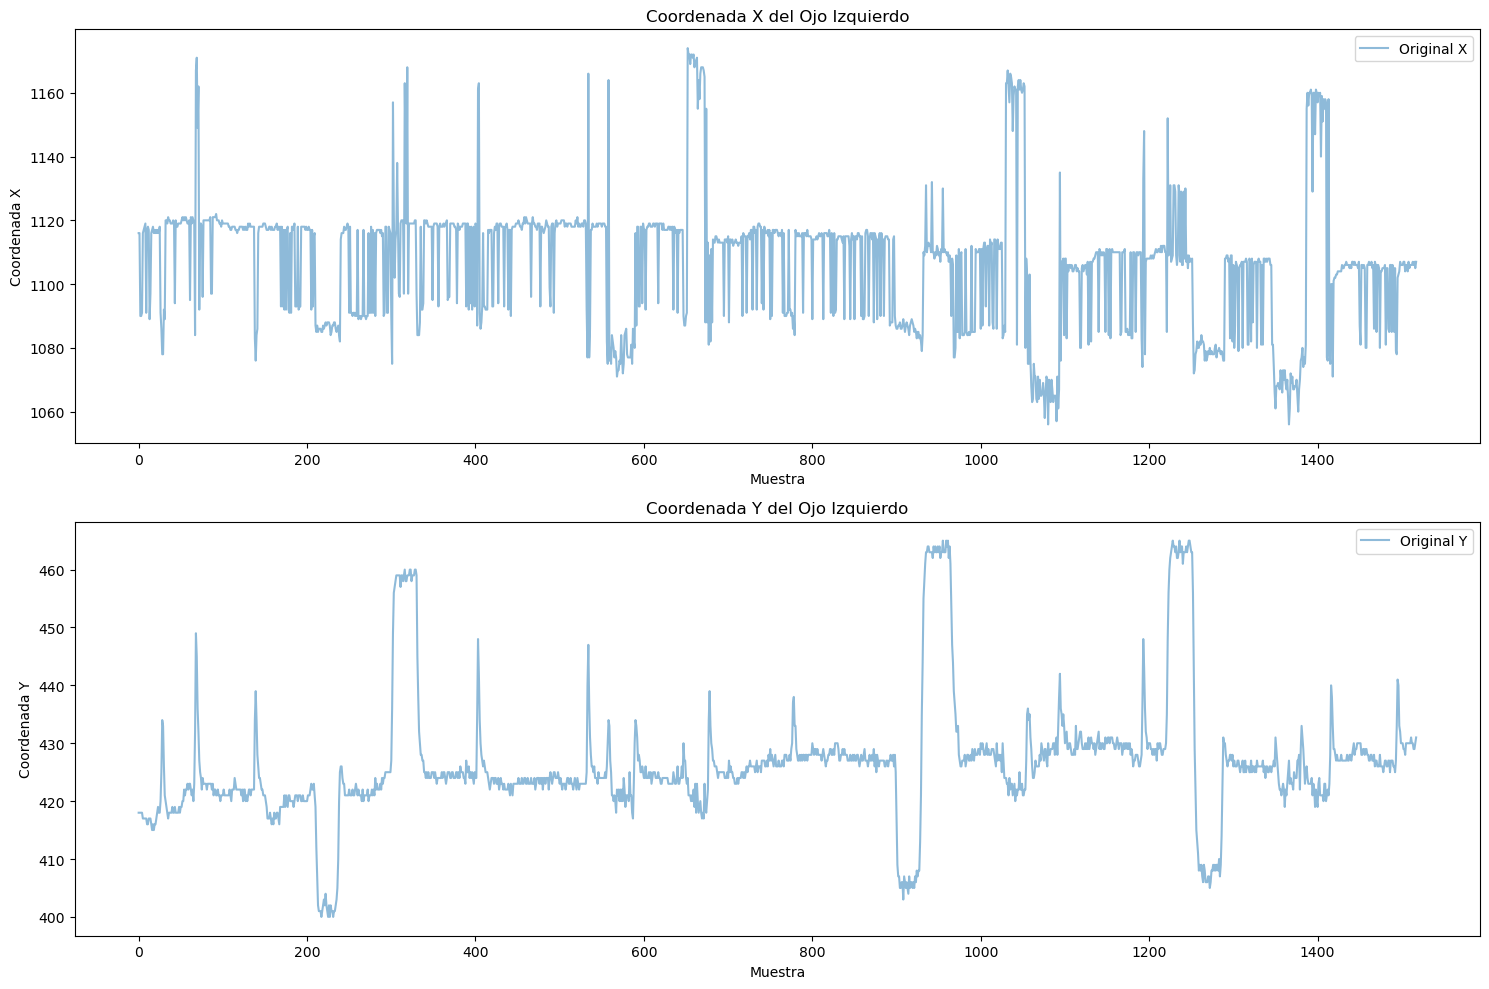

In [27]:
# Extracción de las coordenadas X e Y
x = df['X'].to_numpy()
y = df['Y'].to_numpy()

# Calcular el promedio móvil para las coordenadas X e Y
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

# Calcular el promedio móvil para X e Y
x_moving_avg = moving_average(x, window_size=5)
y_moving_avg = moving_average(y, window_size=5)

# Aplicar suavizado gaussiano a las coordenadas X e Y
x_gaussian_smooth = gaussian_filter(x_moving_avg, sigma=2)
y_gaussian_smooth = gaussian_filter(y_moving_avg, sigma=2)

# Graficar las coordenadas X e Y con promedio móvil y suavizado
plt.figure(figsize=(15, 10))

# Coordenada X
plt.subplot(2, 1, 1)
plt.plot(x, label="Original X", alpha=0.5)
#plt.plot(x_moving_avg, label="Promedio Móvil X", linestyle='--')
#plt.plot(x_gaussian_smooth, label="Suavizado Gaussiano X", linewidth=2)
plt.title("Coordenada X del Ojo Izquierdo")
plt.xlabel("Muestra")
plt.ylabel("Coordenada X")
plt.legend()

# Coordenada Y
plt.subplot(2, 1, 2)
plt.plot(y, label="Original Y", alpha=0.5)
#plt.plot(y_moving_avg, label="Promedio Móvil Y", linestyle='--')
#plt.plot(y_gaussian_smooth, label="Suavizado Gaussiano Y", linewidth=2)
plt.title("Coordenada Y del Ojo Izquierdo")
plt.xlabel("Muestra")
plt.ylabel("Coordenada Y")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
# Guardar los datos procesados en CSV para la coordenada X
df_x = pd.DataFrame({
    'Original X': x,
    'Promedio Móvil X': x_moving_avg,
    'Suavizado Gaussiano X': x_gaussian_smooth
})
df_x.to_csv('6SUJ_x_coordinates.csv', index=False)

# Guardar los datos procesados en CSV para la coordenada Y
df_y = pd.DataFrame({
    'Original Y': y,
    'Promedio Móvil Y': y_moving_avg,
    'Suavizado Gaussiano Y': y_gaussian_smooth
})
df_y.to_csv('6SUJ_y_coordinates.csv', index=False)

print("Los archivos CSV de las coordenadas X e Y procesadas han sido guardados.")


Los archivos CSV de las coordenadas X e Y procesadas han sido guardados.


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">

<h2 style="padding: 10px;
              color:snow;"> Señales procesadas

</h2>
</div>

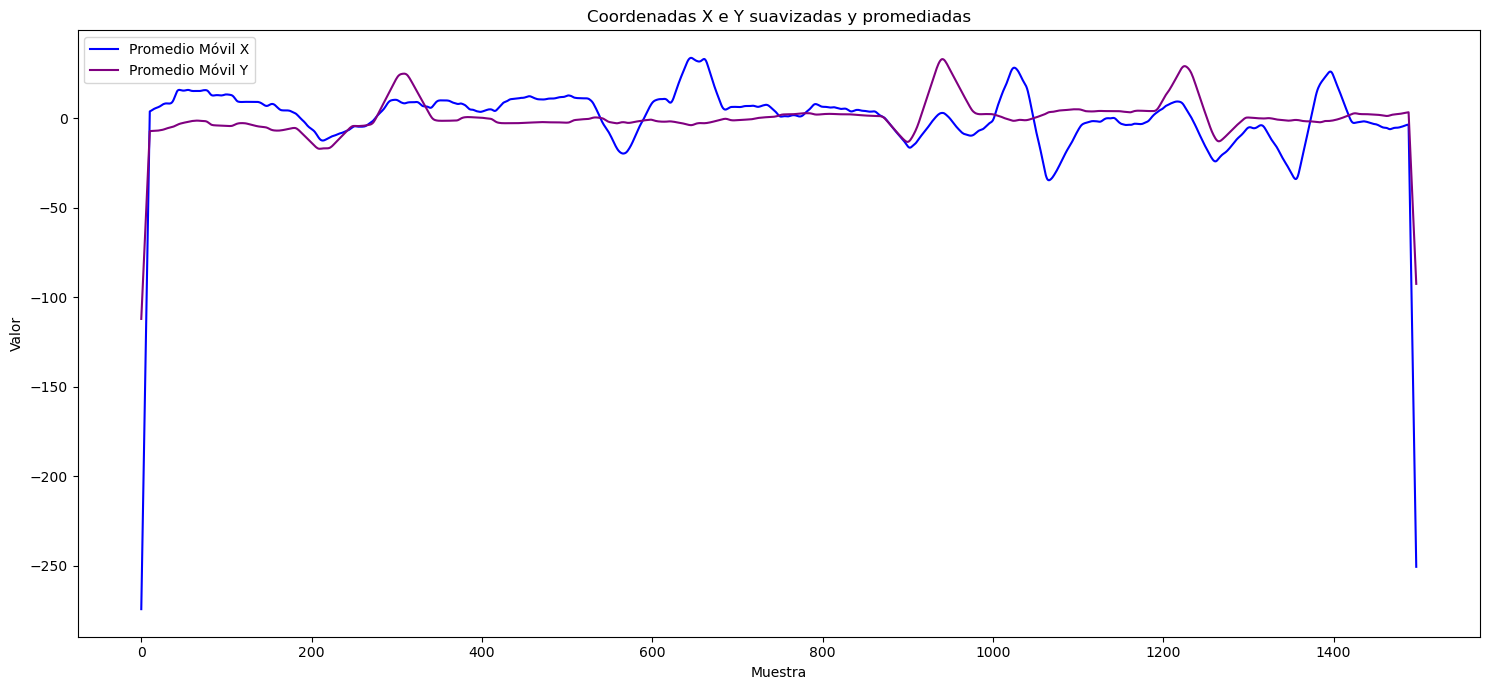

In [41]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Leer los archivos CSV en DataFrames
df_x = pd.read_csv('6SUJ_x_coordinates.csv')
df_y = pd.read_csv('6SUJ_y_coordinates.csv')

# Aplicar suavizado gaussiano
sigma = 2  # Desviación estándar para el suavizado gaussiano
x_gaussian_smooth = gaussian_filter(df_x['Original X'], sigma=sigma)
y_gaussian_smooth = gaussian_filter(df_y['Original Y'], sigma=sigma)

# Definir el tamaño de ventana para el promedio móvil
window_size = 40

# Función de promedio móvil
def moving_average(signal, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(signal, window, 'same')

# Aplicar el promedio móvil a los datos suavizados
x_tmp = moving_average(x_gaussian_smooth, window_size)
y_tmp = moving_average(y_gaussian_smooth, window_size)

x_moving_avg = x_tmp[10:-10]
y_moving_avg = y_tmp[10:-10]

mean_x = np.mean(x_moving_avg)
x_moving_avg = x_moving_avg - mean_x
mean_y = np.mean(y_moving_avg)
y_moving_avg = y_moving_avg - mean_y

# Graficar los datos suavizados y promediados
plt.figure(figsize=(15, 7))

# Coordenadas X e Y superpuestas
plt.plot(x_moving_avg, label='Promedio Móvil X', color='blue')
plt.plot(y_moving_avg, label='Promedio Móvil Y', color='purple')
plt.title('Coordenadas X e Y suavizadas y promediadas')
plt.xlabel('Muestra')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [389]:
#def auto_adjust_y_limits(data, ax, padding_factor=0.1):

   # min_data, max_data = np.min(data), np.max(data)
   # range_data = max_data - min_data
   # padding = range_data * padding_factor
   # new_lim_low = min_data - padding
   # new_lim_high = max_data + padding
   # ax.set_ylim(new_lim_low, new_lim_high)

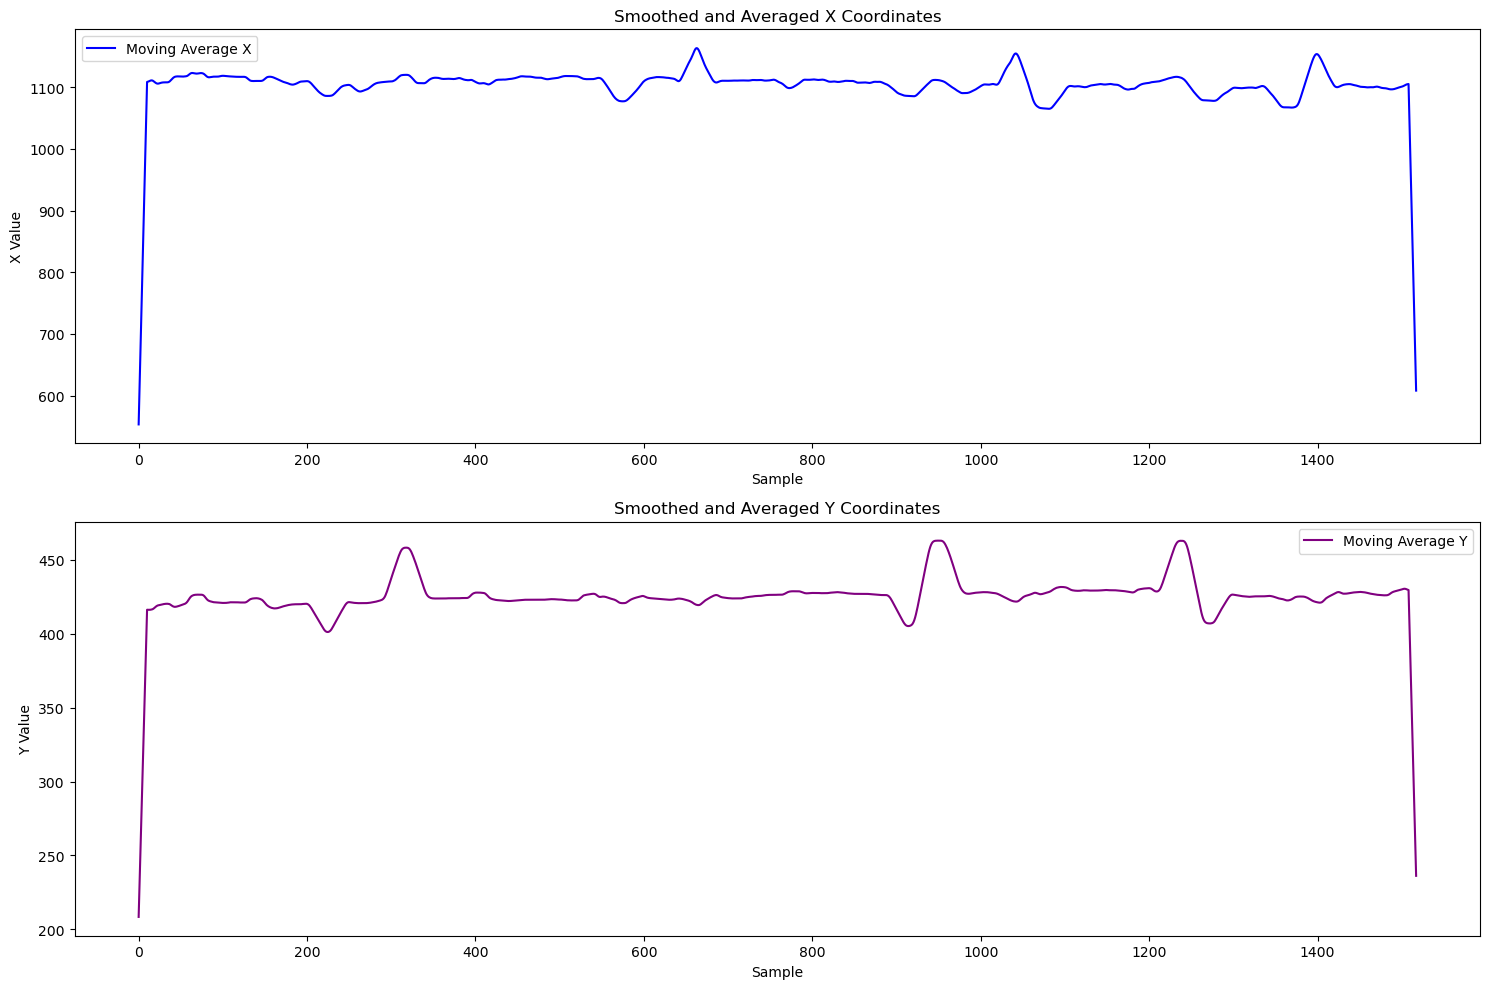

In [30]:
# Read the CSV files into DataFrames
df_x = pd.read_csv('6SUJ_x_coordinates.csv')
df_y = pd.read_csv('6SUJ_y_coordinates.csv')

# Apply Gaussian smoothing
sigma = 2  # Standard deviation for Gaussian smoothing
x_gaussian_smooth = gaussian_filter(df_x['Original X'], sigma=sigma)
y_gaussian_smooth = gaussian_filter(df_y['Original Y'], sigma=sigma)

# Define window size for moving average
window_size = 20

# Moving average function
def moving_average(signal, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(signal, window, 'same')

# Apply moving average to the smoothed data
x_moving_avg = moving_average(x_gaussian_smooth, window_size)
y_moving_avg = moving_average(y_gaussian_smooth, window_size)

# Plotting the smoothed and averaged data
plt.figure(figsize=(15, 10))

# X Coordinates
plt.subplot(2, 1, 1)
plt.plot(x_moving_avg, label='Moving Average X', color='blue')
plt.title('Smoothed and Averaged X Coordinates')
plt.xlabel('Sample')
plt.ylabel('X Value')
plt.legend()

# Y Coordinates
plt.subplot(2, 1, 2)
plt.plot(y_moving_avg, label='Moving Average Y', color='purple')
plt.title('Smoothed and Averaged Y Coordinates')
plt.xlabel('Sample')
plt.ylabel('Y Value')
plt.legend()

plt.tight_layout()
plt.show()


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Codificación de movimiento
    
</h2>
</div>

In [31]:
def codificar_movimiento_ocular(peaks_indices, valleys_indices):
    
    movements = []
    peak_idx, valley_idx = 0, 0
    while peak_idx < len(peaks_indices) or valley_idx < len(valleys_indices):
        if peak_idx < len(peaks_indices) and valley_idx < len(valleys_indices):
            if peaks_indices[peak_idx] < valleys_indices[valley_idx]:
                movements.append('U')
                peak_idx += 1
            else:
                movements.append('D')
                valley_idx += 1
        elif peak_idx < len(peaks_indices):
            movements.append('U')
            peak_idx += 1
        elif valley_idx < len(valleys_indices):
            movements.append('D')
            valley_idx += 1
    return movements

# Interpretar los movimientos oculares en términos de dirección
def interpretar_movimiento(movimientos):
    interpretaciones = []
    for i in range(0, len(movimientos), 2):
        P = movimientos[i]
        if i+1 < len(movimientos):
            V = movimientos[i+1]
        else:
            V = None  # No hay un valle después del último pico
        
        if P == 'U' and V == 'D':
            interpretaciones.append("Derecha")
        elif P == 'D' and V == 'D':
            interpretaciones.append("Centro")
        elif P == 'D' and V == 'U':
            interpretaciones.append("Izquierda")
        else:
            interpretaciones.append("Movimiento no reconocido")
    return interpretaciones


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Detección de picos y valles en señales 
    
</h2>
</div>

Codificación movimientos X: U U D U
Interpretación movimientos X: ['Movimiento no reconocido', 'Izquierda']
Codificación movimientos Y: U D U D U U D U
Interpretación movimientos Y: ['Derecha', 'Derecha', 'Movimiento no reconocido', 'Izquierda']


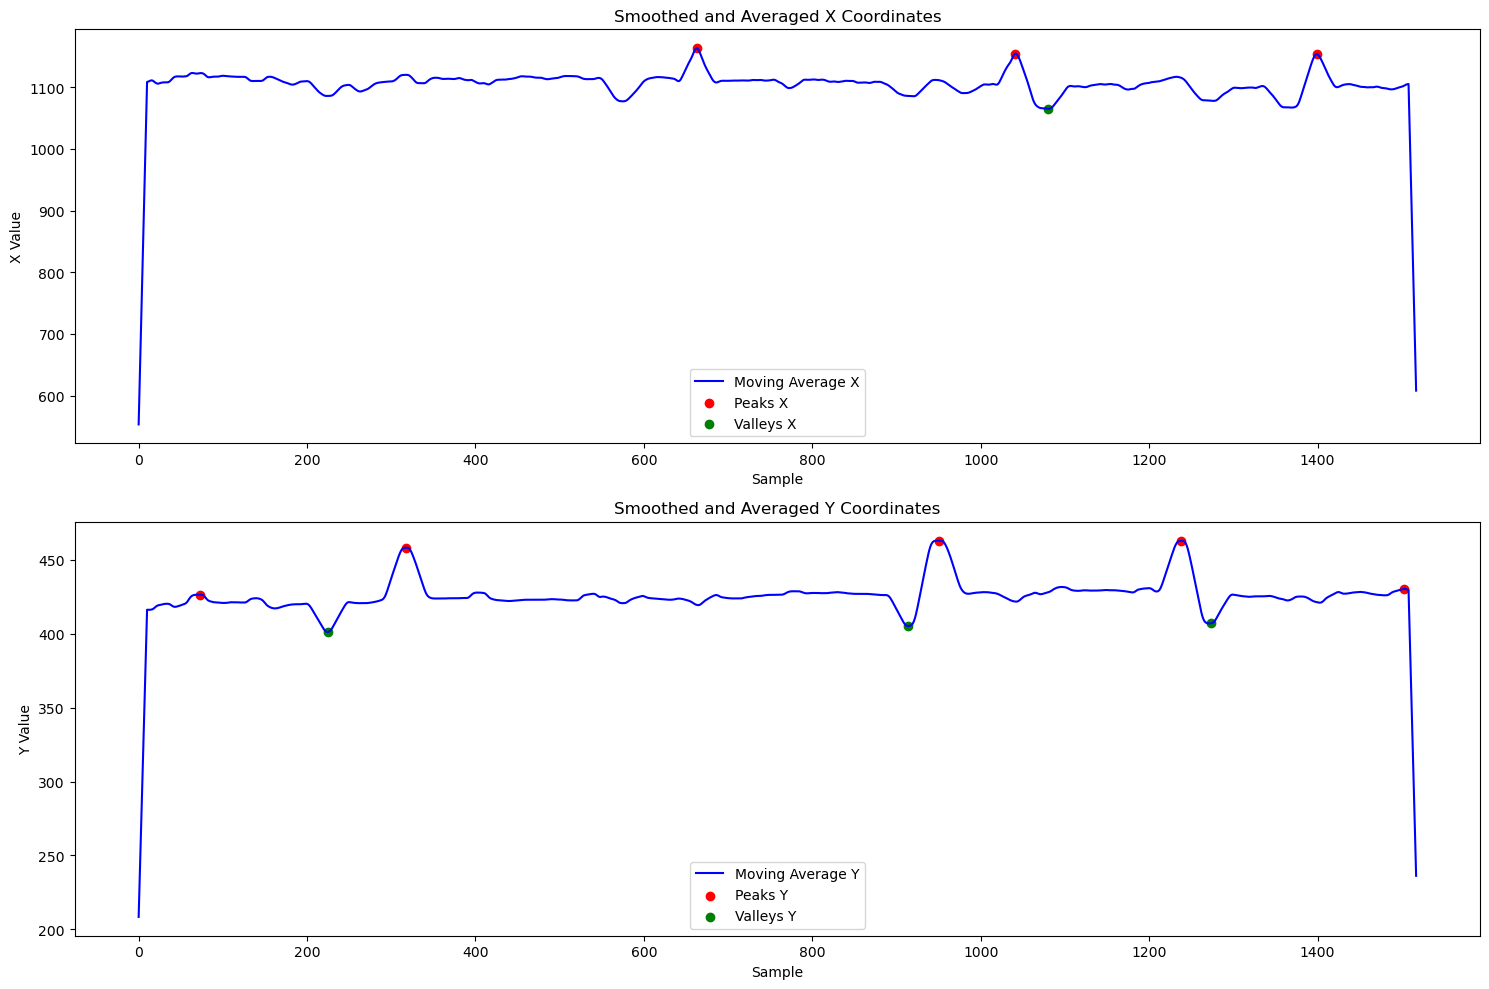

In [33]:
df_x = pd.read_csv('6SUJ_x_coordinates.csv') 
df_y = pd.read_csv('6SUJ_y_coordinates.csv') 
sigma = 2  
x_gaussian_smooth = gaussian_filter(df_x['Original X'], sigma=sigma)
y_gaussian_smooth = gaussian_filter(df_y['Original Y'], sigma=sigma)

# Define window size for moving average
window_size = 20

# Moving average function
def moving_average(signal, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(signal, window, 'same')

# Apply moving average to the smoothed data
x_moving_avg = moving_average(x_gaussian_smooth, window_size)
y_moving_avg = moving_average(y_gaussian_smooth, window_size)

# Parameters for peak detection
prominence_x = np.max(x_moving_avg) * 0.05
prominence_y = np.max(y_moving_avg) * 0.025  
distance = 200 # minimum number of samples between successive peaks

# Find peaks (puntos altos) and valleys (puntos bajos) in the X data#
peaks_x, _ = find_peaks(x_moving_avg, prominence=prominence_x, distance=distance)
valleys_x, _ = find_peaks(-x_moving_avg, prominence=prominence_x, distance=distance)

# Find peaks and valleys in the Y data
peaks_y, _ = find_peaks(y_moving_avg, prominence=prominence_y, distance=distance)
valleys_y, _ = find_peaks(-y_moving_avg, prominence=prominence_y, distance=distance)

# Aplicar la codificación y la interpretación al movimiento ocular
movimientos_codificados_x = codificar_movimiento_ocular(peaks_x, valleys_x)
movimientos_codificados_y = codificar_movimiento_ocular(peaks_y, valleys_y)

interpretaciones_x = interpretar_movimiento(movimientos_codificados_x)
interpretaciones_y = interpretar_movimiento(movimientos_codificados_y)

# Imprimir tanto la codificación como la interpretación de los movimientos oculares
print("Codificación movimientos X:", ' '.join(movimientos_codificados_x))
print("Interpretación movimientos X:", interpretaciones_x)
print("Codificación movimientos Y:", ' '.join(movimientos_codificados_y))
print("Interpretación movimientos Y:", interpretaciones_y)


output_directory = 'VISION-PV-C'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


plt.figure(figsize=(15, 10))

# X Coordinates plot
plt.subplot(2, 1, 1)
plt.plot(x_moving_avg, label='Moving Average X', color='blue')
plt.scatter(peaks_x, x_moving_avg[peaks_x], color='red', label='Peaks X')
plt.scatter(valleys_x, x_moving_avg[valleys_x], color='green', label='Valleys X')
plt.title('Smoothed and Averaged X Coordinates')
plt.xlabel('Sample')
plt.ylabel('X Value')
plt.legend()


# Y Coordinates plot
plt.subplot(2, 1, 2)
plt.plot(y_moving_avg, label='Moving Average Y', color='blue')
plt.scatter(peaks_y, y_moving_avg[peaks_y], color='red', label='Peaks Y')
plt.scatter(valleys_y, y_moving_avg[valleys_y], color='green', label='Valleys Y')
plt.title('Smoothed and Averaged Y Coordinates')
plt.xlabel('Sample')
plt.ylabel('Y Value')
plt.legend()

plt.tight_layout()


plt.savefig(os.path.join(output_directory, '6SUJ_XY_Coordinates.png'))

plt.show()


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Codificación de movimiento para coordenada X
    
</h2>
</div>

In [34]:
def codificar_movimiento_ocular(peaks_indices, valleys_indices):
    movements = []
    peak_idx, valley_idx = 0, 0
    while peak_idx < len(peaks_indices) or valley_idx < len(valleys_indices):
        if peak_idx < len(peaks_indices) and valley_idx < len(valleys_indices):
            if peaks_indices[peak_idx] < valleys_indices[valley_idx]:
                movements.append('U')
                peak_idx += 1
            else:
                movements.append('D')
                valley_idx += 1
        elif peak_idx < len(peaks_indices):
            movements.append('U')
            peak_idx += 1
        elif valley_idx < len(valleys_indices):
            movements.append('D')
            valley_idx += 1
    return movements

# Interpretar los movimientos oculares en términos de dirección
def interpretar_movimiento(movimientos):
    interpretaciones = []
    for i in range(0, len(movimientos), 2):
        P = movimientos[i]
        if i+1 < len(movimientos):
            V = movimientos[i+1]
        else:
            V = None  # No hay un valle después del último pico
        
        if P == 'U' and V == 'D':
            interpretaciones.append("Izquierda Derecha")
        elif P == 'D' and V == 'D':
            interpretaciones.append("Centro")
        elif P == 'D' and V == 'U':
            interpretaciones.append("Derecha Izquierda")
        else:
            interpretaciones.append("Movimiento no reconocido")
    return interpretaciones

<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Detección de picos y valles en señal X 
    
</h2>
</div>

Codificación movimientos X: U U D U
Interpretación movimientos X: ['Movimiento no reconocido', 'Derecha Izquierda']


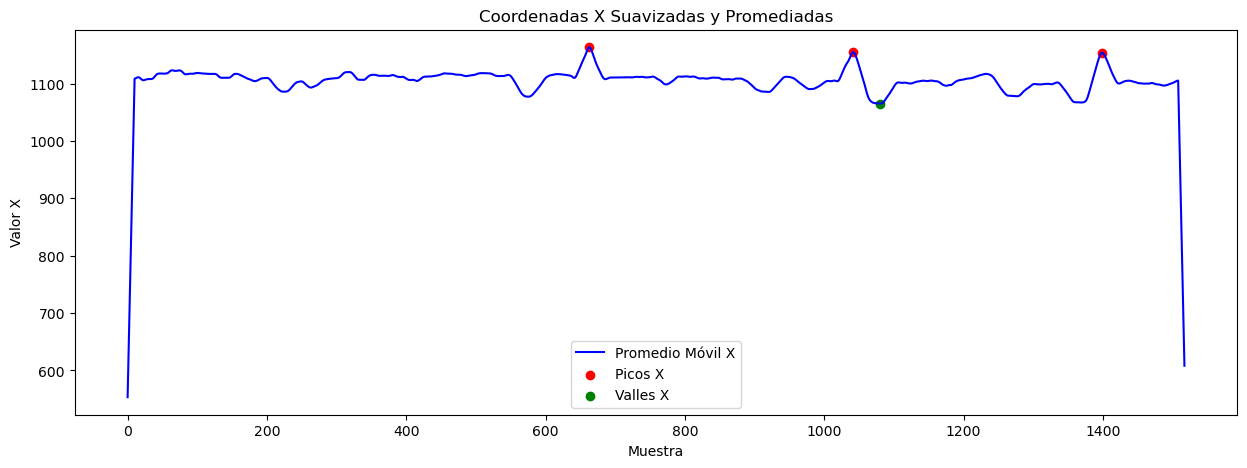

In [35]:
df_x = pd.read_csv('6SUJ_x_coordinates.csv')  # Asegúrate de que tu archivo CSV tenga una columna llamada 'Original X'

# Aplica suavizado gaussiano
sigma = 2  # Desviación estándar para el suavizado gaussiano
x_gaussian_smooth = gaussian_filter(df_x['Original X'], sigma=sigma)

# Define el tamaño de la ventana para el promedio móvil
window_size = 20

# Función de promedio móvil
def moving_average(signal, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(signal, window, 'same')

# Aplica el promedio móvil a los datos suavizados
x_moving_avg = moving_average(x_gaussian_smooth, window_size)

# Parámetros para la detección de picos
prominence_x = np.max(x_moving_avg) * 0.05
distance = 200  # Número mínimo de muestras entre picos sucesivos

# Encuentra picos (puntos altos) y valles (puntos bajos) en los datos X
peaks_x, _ = find_peaks(x_moving_avg, prominence=prominence_x, distance=distance)
valleys_x, _ = find_peaks(-x_moving_avg, prominence=prominence_x, distance=distance)

# Aplicar la codificación y la interpretación al movimiento ocular
movimientos_codificados_x = codificar_movimiento_ocular(peaks_x, valleys_x)
interpretaciones_x = interpretar_movimiento(movimientos_codificados_x)

# Imprimir tanto la codificación como la interpretación de los movimientos oculares
print("Codificación movimientos X:", ' '.join(movimientos_codificados_x))
print("Interpretación movimientos X:", interpretaciones_x)

# Visualización
plt.figure(figsize=(15, 5))
plt.plot(x_moving_avg, label='Promedio Móvil X', color='blue')
plt.scatter(peaks_x, x_moving_avg[peaks_x], color='red', label='Picos X')
plt.scatter(valleys_x, x_moving_avg[valleys_x], color='green', label='Valles X')

# Añadir interpretaciones como etiquetas
#for i, txt in enumerate(interpretaciones_x):
    #if i < len(peaks_x):
        #plt.text(peaks_x[i], x_moving_avg[peaks_x[i]], txt, fontsize=8)
    #else:
        #plt.text(valleys_x[i-len(peaks_x)], x_moving_avg[valleys_x[i-len(peaks_x)]], txt, fontsize=8)


plt.title('Coordenadas X Suavizadas y Promediadas')
plt.xlabel('Muestra')
plt.ylabel('Valor X')

plt.legend()

# Guarda la figura
output_directory = 'VISION-PV-C'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
plt.savefig(os.path.join(output_directory, '6SUJ_X_Coordinates.png'))

plt.show()


<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Codificación de movimiento para coordenada Y
    
</h2>
</div>

In [36]:
def codificar_movimiento_ocular(peaks_indices, valleys_indices):
   
    movements = []
    peak_idx, valley_idx = 0, 0
    while peak_idx < len(peaks_indices) or valley_idx < len(valleys_indices):
        if peak_idx < len(peaks_indices) and valley_idx < len(valleys_indices):
            if peaks_indices[peak_idx] < valleys_indices[valley_idx]:
                movements.append('U')
                peak_idx += 1
            else:
                movements.append('D')
                valley_idx += 1
        elif peak_idx < len(peaks_indices):
            movements.append('U')
            peak_idx += 1
        elif valley_idx < len(valleys_indices):
            movements.append('D')
            valley_idx += 1
    return movements

# Interpretar los movimientos oculares en términos de dirección
def interpretar_movimiento(movimientos):
    interpretaciones = []
    for i in range(0, len(movimientos), 2):
        P = movimientos[i]
        if i+1 < len(movimientos):
            V = movimientos[i+1]
        else:
            V = None  # No hay un valle después del último pico
        
        if P == 'U' and V == 'D':
            interpretaciones.append("Abajo Arriba")
        elif P == 'D' and V == 'D':
            interpretaciones.append("Centro")
        elif P == 'D' and V == 'U':
            interpretaciones.append("Arriba Abajo")
        else:
            interpretaciones.append("Movimiento no reconocido")
    return interpretaciones

<center>
<div style="color:;
           display:fill;
           border-radius:2px;
           background-color: lightsteelblue ;
           font-size:110%;
           letter-spacing:0.6px">
<h2 style="padding: 10px;
              color:snow;"> Detección de picos y valles en señal Y 
    
</h2>
</div>

Codificación movimientos Y: U D U D U U D U
Interpretación movimientos Y: ['Abajo Arriba', 'Abajo Arriba', 'Movimiento no reconocido', 'Arriba Abajo']


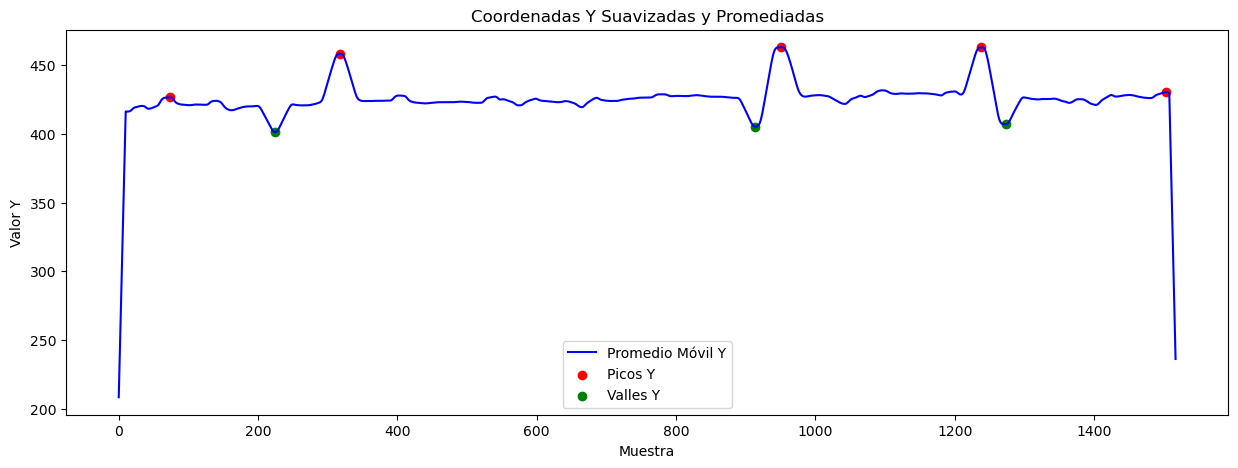

In [37]:
df_y = pd.read_csv('6SUJ_y_coordinates.csv')

# Aplica suavizado gaussiano
sigma = 2  # Desviación estándar para el suavizado gaussiano
y_gaussian_smooth = gaussian_filter(df_y['Original Y'], sigma=sigma)

# Define el tamaño de la ventana para el promedio móvil
window_size = 20

# Función de promedio móvil
def moving_average(signal, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(signal, window, 'same')
    
# Aplica el promedio móvil a los datos suavizados
y_moving_avg = moving_average(y_gaussian_smooth, window_size)

# Ajusta los parámetros de detección de picos para Y
prominence_y = np.max(y_moving_avg) * 0.025 # Ajusta según sea necesario
distance = 200  # Número mínimo de muestras entre picos sucesivos

# Encuentra picos y valles en los datos Y
peaks_y, _ = find_peaks(y_moving_avg, prominence=prominence_y, distance=distance)
valleys_y, _ = find_peaks(-y_moving_avg, prominence=prominence_y, distance=distance)

# Aplicar la codificación y la interpretación al movimiento ocular
movimientos_codificados_y = codificar_movimiento_ocular(peaks_y, valleys_y)
interpretaciones_y = interpretar_movimiento(movimientos_codificados_y)

print("Codificación movimientos Y:", ' '.join(movimientos_codificados_y))
print("Interpretación movimientos Y:", interpretaciones_y)


# Visualización similar al script de coordenadas X, pero ajustada para Y

plt.figure(figsize=(15, 5))
plt.plot(y_moving_avg, label='Promedio Móvil Y', color='blue')
plt.scatter(peaks_y, y_moving_avg[peaks_y], color='red', label='Picos Y')
plt.scatter(valleys_y, y_moving_avg[valleys_y], color='green', label='Valles Y')

# Añadir interpretaciones como etiquetas
#for i, txt in enumerate(interpretaciones_y):
    #if i < len(peaks_y):
        #plt.text(peaks_y[i], y_moving_avg[peaks_y[i]], txt, fontsize=8)
    #else:
        #plt.text(valleys_y[i-len(peaks_y)], y_moving_avg[valleys_y[i-len(peaks_y)]], txt, fontsize=8)

plt.title('Coordenadas Y Suavizadas y Promediadas')
plt.xlabel('Muestra')
plt.ylabel('Valor Y')
plt.legend()

# Guarda la figura
output_directory = 'VISION-PV-C'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
plt.savefig(os.path.join(output_directory, '6SUJ_Y_Coordinates.png'))

plt.show()